In [1]:
try:
    import google.colab
    IN_COLAB = True
    %pip uninstall scikit-learn -y
    %pip install scikit-learn
    %pip install jaxtyping
    from tqdm.notebook import tqdm, trange

    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    %cd /content/gdrive/MyDrive/CCS/_experiment4
except:
    IN_COLAB = False
    from tqdm import tqdm, trange

In [2]:
import os, sys, gc, pickle
sys.path.append("../utils")

import numpy as np
import pandas as pd

import torch as t

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# from CCS import CCS
# from CRC import CRC
# from utils import fit_logreg
# from norm import normalize_burns, normalize_cluster

In [3]:
prompts_tqa = pd.read_json("prompts_tqa.jsonl", orient="records", lines=True)
prompts_cc = pd.read_json("prompts_cc.jsonl", orient="records", lines=True)

labels_tqa = prompts_tqa["label"].values
labels_cc = prompts_cc["label"].values

model = "llama"
layer = 23

colours = {"default": "blue", "literal": "red", "professor": "green"}
legend_elements = [
    mpatches.Patch(facecolor="blue", label="Default"),
    mpatches.Patch(facecolor="red", label="Literal"),
    mpatches.Patch(facecolor="green", label="Professor")
]

pca_colour_map = {0: "blue", 1: "orange"}
pca_legend_elements = [
        mpatches.Patch(facecolor=pca_colour_map[0], label="False"),
        mpatches.Patch(facecolor=pca_colour_map[1], label="True")
]

### zero shot

In [4]:
out = pd.DataFrame(columns=["default", "literal", "professor"])
for dataset, labels in zip(["tqa", "cc"], [labels_tqa, labels_cc]):
    accs = []
    for template in ["default", "literal", "professor"]:
        infile = open(f"logits/{template}-{dataset}.pickle", "rb")
        preds = pickle.load(infile); infile.close()
        preds = np.array([int(eval(x)) for x in preds])
        acc = (preds == labels).mean()
        accs.append(round(acc, 2))
    out.loc[dataset] = accs
display(out)

,default,literal,professor
tqa,0.53,0.45,0.48
cc,0.71,0.71,0.55


### logistic regression

In [31]:
from cluster_norm.utils.train import fit_logreg


out = pd.DataFrame(columns=["default", "literal", "professor"])

for dataset, labels in zip(["tqa", "cc"], [labels_tqa, labels_cc]):
    perm = t.randperm(len(labels))
    accs = []
    for template in ["default", "literal", "professor"]:
        pos = t.load(f"activations/{model}/layer{layer}/{template}-True-{dataset}.pt")[perm]
        neg = t.load(f"activations/{model}/layer{layer}/{template}-False-{dataset}.pt")[perm]

        split = int(0.7*len(pos))
        X_train_pos, X_test_pos = pos[:split], pos[split:]
        X_train_neg, X_test_neg = neg[:split], neg[split:]
        y_train, y_test = labels[perm][:split], labels[perm][split:]
        lr = LogisticRegression(max_iter=10000)
        lr.fit(X_train_pos-X_train_neg, y_train)
        acc = lr.score(X_test_pos-X_test_neg, y_test)
    
        accs.append(round(acc, 2))
    out.loc[dataset] = accs
display(out)

,default,literal,professor
tqa,0.80,0.81,0.82
cc,0.79,0.81,0.80


### crc-tpc

CRC norm burns
CRC norm burns
CRC norm burns
CRC norm cluster
CRC norm cluster
CRC norm cluster
CRC norm burns
CRC norm burns
CRC norm burns
CRC norm cluster
CRC norm cluster
CRC norm cluster


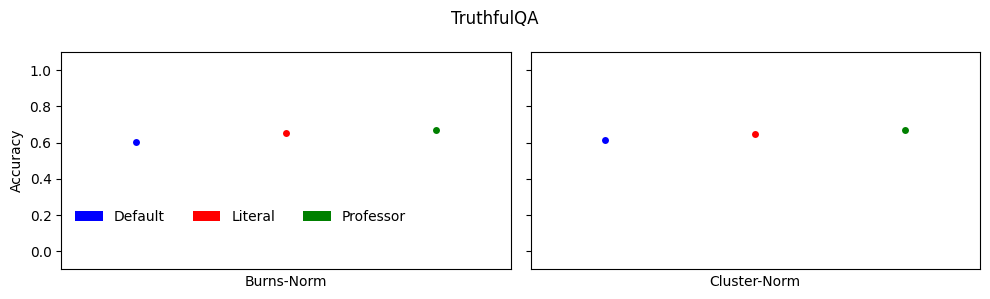

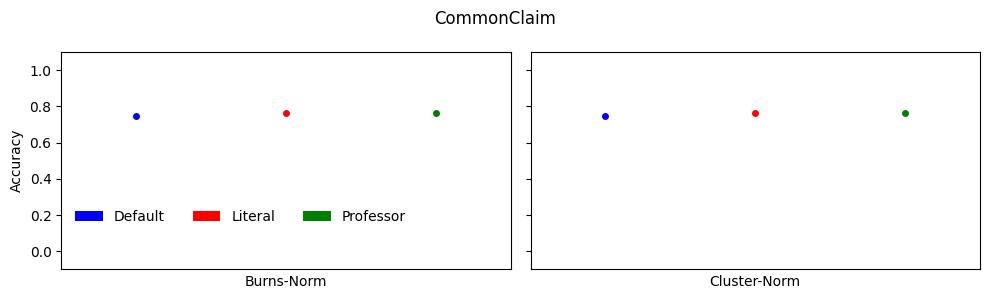

In [35]:
from cluster_norm.utils.CRC import CRC


def get_crc(normalize, dataset, labels, perm):
    crc = CRC()
    accuracies, templates = [], []
    
    for template in ["default", "literal", "professor"]:
        pos = t.load(f"activations/{model}/layer{layer}/{template}-True-{dataset}.pt")[perm]
        neg = t.load(f"activations/{model}/layer{layer}/{template}-False-{dataset}.pt")[perm]

        crc.fit(pos, neg, normalize)
        acc = crc.evaluate(pos, neg, labels[perm])
        accuracies.append(acc)
        templates.append(template)
    df = pd.DataFrame()
    df["template"] = templates
    df["accuracy"] = accuracies
    return df


perm = t.randperm(len(labels_tqa))
burns_tqa = get_crc("burns", "tqa", labels_tqa, perm)
cluster_tqa = get_crc("cluster", "tqa", labels_tqa, perm)

perm = t.randperm(len(labels_cc))
burns_cc = get_crc("burns", "cc", labels_cc, perm)
cluster_cc = get_crc("cluster", "cc", labels_cc, perm)

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, squeeze=True, figsize=(10, 3))
for ax, df, label in zip(axs, [burns_tqa, cluster_tqa], ["Burns-Norm", "Cluster-Norm"]):
    sns.stripplot(x="template", y="accuracy", data=df, ax=ax, palette=colours, hue="template", marker="o")
    ax.set_xticks([], [])
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel(label)
axs[0].set_ylabel("Accuracy")
plt.suptitle("TruthfulQA")
plt.figlegend(handles=legend_elements, loc="lower left", ncol=3, labelspacing=0.1,
              borderaxespad=5., frameon=False, fontsize="medium")
plt.tight_layout()
plt.show()
print()
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, squeeze=True, figsize=(10, 3))
for ax, df, label in zip(axs, [burns_cc, cluster_cc], ["Burns-Norm", "Cluster-Norm"]):
    sns.stripplot(x="template", y="accuracy", data=df, ax=ax, palette=colours, hue="template", marker="o")
    ax.set_xticks([], [])
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel(label)
axs[0].set_ylabel("Accuracy")
plt.suptitle("CommonClaim")
plt.figlegend(handles=legend_elements, loc="lower left", ncol=3, labelspacing=0.1,
              borderaxespad=5., frameon=False, fontsize="medium")
plt.tight_layout()
plt.show()

### pca

In [20]:
from cluster_norm.utils.norm import normalize_cluster


def plot_pca(dataset, labels, plot_title, normalize):
    colours = [pca_colour_map[l] for l in labels]
    fig = plt.figure(figsize=(10, 4))
    for i, template in enumerate(["default", "literal", "professor"]):
        pos = t.load(f"activations/{model}/layer{layer}/{template}-True-{dataset}.pt")
        neg = t.load(f"activations/{model}/layer{layer}/{template}-False-{dataset}.pt")
        if normalize: pos, neg = normalize_cluster(pos, neg, device=pos.device)
        pca = PCA(n_components=3)
        X = pca.fit_transform(pos - neg)
        ax = fig.add_subplot(1, 3, i+1, projection="3d")
        ax.view_init(elev=45, azim=45)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colours, alpha=0.5)
        title = f"{template[0].upper()}{template[1:]}"
        ax.set_title(title, y=0, pad=-25, verticalalignment="top")
    plt.suptitle(plot_title)
    plt.figlegend(handles=pca_legend_elements)
    plt.tight_layout()
    plt.show()

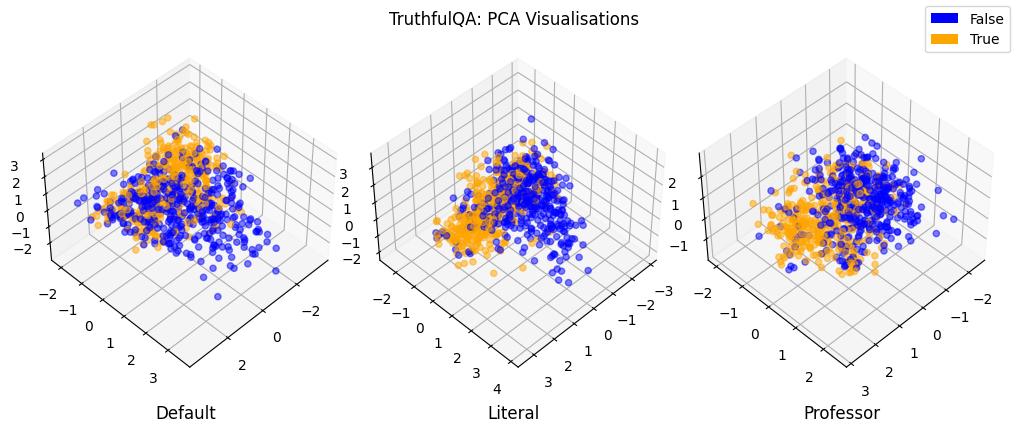

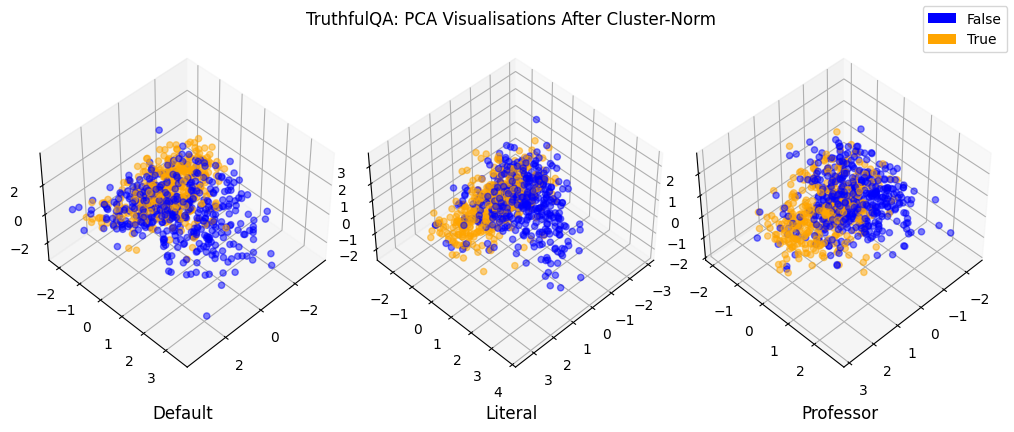

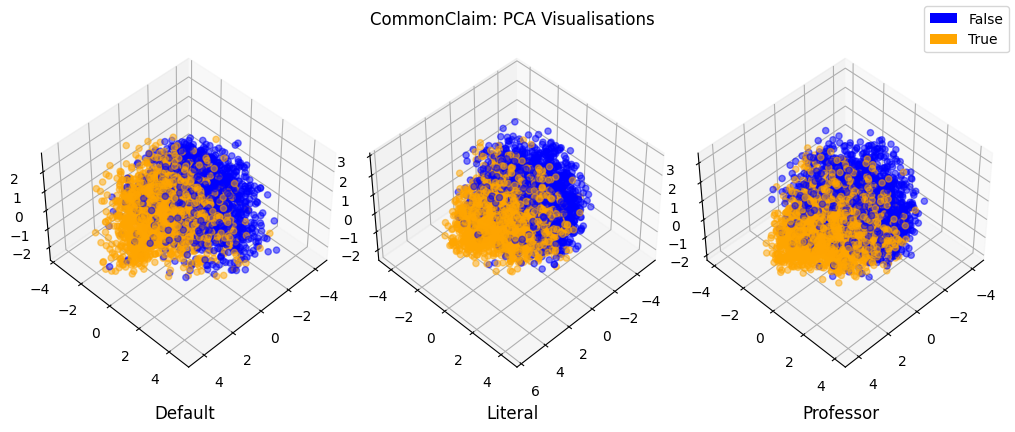

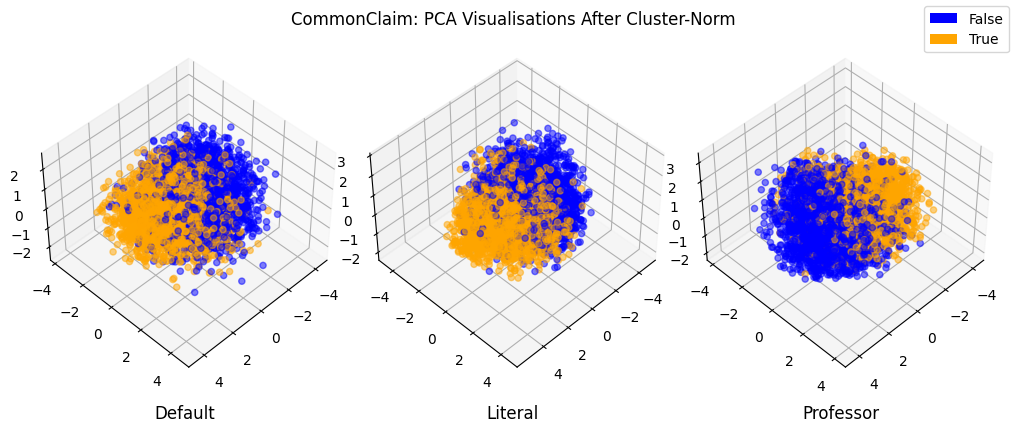

In [21]:
plot_pca("tqa", labels_tqa, "TruthfulQA: PCA Visualisations", False)
print()
plot_pca("tqa", labels_tqa, "TruthfulQA: PCA Visualisations After Cluster-Norm", True)
print()
plot_pca("cc", labels_cc, "CommonClaim: PCA Visualisations", False)
print()
plot_pca("cc", labels_cc, "CommonClaim: PCA Visualisations After Cluster-Norm", True)

### ccs

In [32]:
from cluster_norm.utils.CCS import CCS


def get_ccs(normalize, dataset, labels):
    accuracies = []
    templates = []
    perm = t.randperm(len(labels))
    for template in ["default", "literal", "professor"]:
        pos = t.load(f"activations/{model}/layer{layer}/{template}-True-{dataset}.pt")[perm]
        neg = t.load(f"activations/{model}/layer{layer}/{template}-False-{dataset}.pt")[perm]
        ccs = CCS(
                pos=pos,
                neg=neg,
                normalize=normalize,
                n_probe=5,
                device=t.device("cuda")
            )
        ccs.optimize()
        for probe in ccs.probes:
            preds = ccs.predict(probe, pos, neg)
            acc = (preds == labels[perm]).mean(); acc = max(acc, 1-acc)
            accuracies.append(acc)
            templates.append(template)
    df = pd.DataFrame()
    df["template"] = templates
    df["accuracy"] = accuracies
    return df

CCS norm burns


fitting probes:   0%|          | 0/5 [00:00<?, ?it/s]/home/laurito/miniconda3/envs/cluster/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
fitting probes: 100%|██████████| 5/5 [02:10<00:00, 26.13s/it]


CCS norm burns


fitting probes: 100%|██████████| 5/5 [02:05<00:00, 25.06s/it]


CCS norm burns


fitting probes: 100%|██████████| 5/5 [02:08<00:00, 25.60s/it]


CCS norm cluster


fitting probes: 100%|██████████| 5/5 [01:17<00:00, 15.55s/it]


CCS norm cluster


fitting probes: 100%|██████████| 5/5 [00:44<00:00,  8.94s/it]


CCS norm cluster


fitting probes: 100%|██████████| 5/5 [01:49<00:00, 21.83s/it]


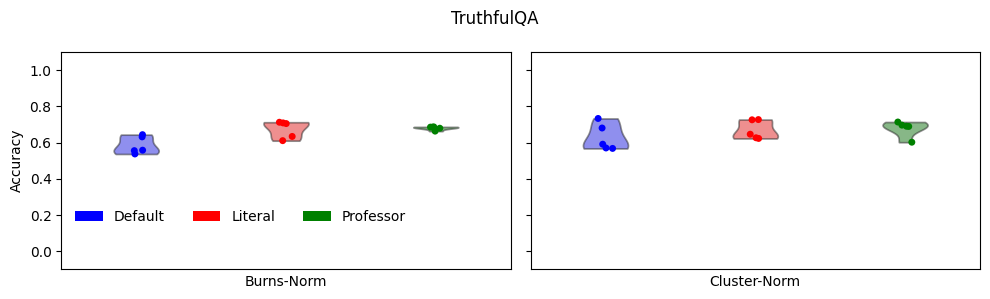

In [33]:
burns_tqa = get_ccs("burns", "tqa", labels_tqa)
cluster_tqa = get_ccs("cluster", "tqa", labels_tqa)

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, squeeze=True, figsize=(10, 3))
for ax, df, label in zip(axs, [burns_tqa, cluster_tqa], ["Burns-Norm", "Cluster-Norm"]):
    sns.stripplot(x="template", y="accuracy", data=df, jitter=0.05, ax=ax, palette=colours, hue="template")
    sns.violinplot(x="template", y="accuracy", data=df, ax=ax, palette=colours, hue="template",
                cut=0, inner=None, width=0.3, alpha=0.5)
    ax.set_xticks([], [])
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel(label)
axs[0].set_ylabel("Accuracy")
plt.suptitle("TruthfulQA")
plt.figlegend(handles=legend_elements, loc="lower left", ncol=3, labelspacing=0.1,
              borderaxespad=5., frameon=False, fontsize="medium")
plt.tight_layout()
plt.show()

CCS norm burns


fitting probes: 100%|██████████| 5/5 [11:46<00:00, 141.35s/it]


CCS norm burns


fitting probes: 100%|██████████| 5/5 [11:10<00:00, 134.13s/it]


CCS norm burns


fitting probes: 100%|██████████| 5/5 [11:25<00:00, 137.04s/it]


CCS norm cluster


fitting probes: 100%|██████████| 5/5 [11:56<00:00, 143.26s/it]


CCS norm cluster


fitting probes: 100%|██████████| 5/5 [12:06<00:00, 145.37s/it]


CCS norm cluster


fitting probes: 100%|██████████| 5/5 [11:47<00:00, 141.54s/it]


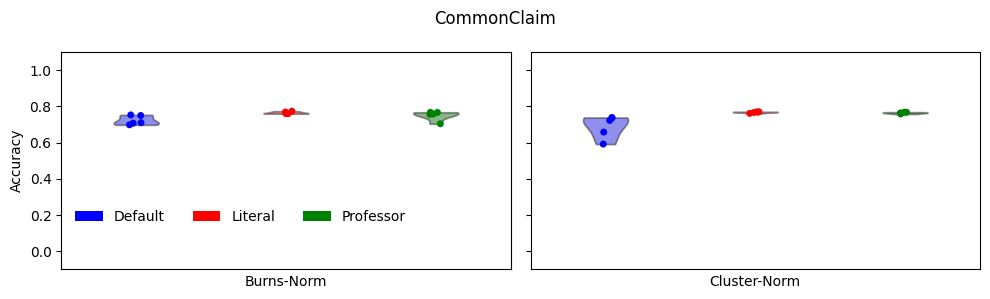

In [34]:
burns_cc = get_ccs("burns", "cc", labels_cc)
cluster_cc = get_ccs("cluster", "cc", labels_cc)

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, squeeze=True, figsize=(10, 3))
for ax, df, label in zip(axs, [burns_cc, cluster_cc], ["Burns-Norm", "Cluster-Norm"]):
    sns.stripplot(x="template", y="accuracy", data=df, jitter=0.05, ax=ax, palette=colours, hue="template")
    sns.violinplot(x="template", y="accuracy", data=df, ax=ax, palette=colours, hue="template",
                cut=0, inner=None, width=0.3, alpha=0.5)
    ax.set_xticks([], [])
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel(label)
axs[0].set_ylabel("Accuracy")
plt.suptitle("CommonClaim")
plt.figlegend(handles=legend_elements, loc="lower left", ncol=3, labelspacing=0.1,
              borderaxespad=5., frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()